# Import libraries

In [4]:
import tensorflow as tf 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,  Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input,BatchNormalization, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, History, TensorBoard,ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import time 
import re
import os
import cv2
history = History()
#%matplotlib inline

In [5]:
#dirname = r"D:\TESIS\6000 datos_Mexican\Datos\P1\Mexican_Hat_img_augmentation"
dirname = r"C:\Users\hpalm\Downloads\P01\P01"

#dirname = r"D:\Nuevas Imagenes\all_to_one2" 

imgpath = dirname+os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0
IMAGE_SIZE = (32, 32)

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            image = cv2.resize(image, IMAGE_SIZE)
            #image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR) 
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0

dircount.append(cant)

#dircount=dircount[1:]
#dircount[0]=dircount[0] + 1

if len(dircount) > 1:
    dircount=dircount[1:]
    dircount[0]=dircount[0]+1  
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  C:\Users\hpalm\Downloads\P01\P01\
C:\Users\hpalm\Downloads\P01\P01\Clase_1 1
C:\Users\hpalm\Downloads\P01\P01\Clase_2 2256
C:\Users\hpalm\Downloads\P01\P01\Clase_3 2256
C:\Users\hpalm\Downloads\P01\P01\Clase_4 2256
C:\Users\hpalm\Downloads\P01\P01\Clase_5 2256
C:\Users\hpalm\Downloads\P01\P01\Clase_6 2256
Directorios leidos: 6
Imagenes en cada directorio [2257, 2256, 2256, 2256, 2256, 2255]
suma Total de imagenes en subdirs: 13536


# **DATA PREPARATION**

In [6]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)   
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

Cantidad etiquetas creadas:  13536


In [7]:
posturas=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    posturas.append(name[len(name)-1])
    indice=indice+1

0 Clase_1
1 Clase_2
2 Clase_3
3 Clase_4
4 Clase_5
5 Clase_6


In [8]:
y = np.array(labels)
X = np.array(images) #convierto de lista a numpy

#X = tf.convert_to_tensor(X,dtype=tf.float32) # convertir de arrays a tensors
#y = tf.convert_to_tensor(X,dtype=tf.float32)

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  6
Output classes :  [0 1 2 3 4 5]


In [9]:
# Test data // for testing at the end after tranning 
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.1)


#print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

# validation data // for testing when tranning 

#train_X,val_X,train_Y,val_Y = train_test_split(train_X,train_Y,test_size=0.1)
#print('Training data shape : ', train_X.shape, train_Y.shape)
#print('validation data shape : ', val_X.shape, val_Y.shape)

Testing data shape :  (1354, 32, 32, 3) (1354,)


# **CNN Training**

In [15]:

img_x = 128
img_y = 128
img_z = 3
num_classes = 6

batch_size = 32
epochs = 100

# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# because the MNIST is greyscale, we only have a single channel - RGB colour images would have 3
input_shape = (img_x, img_y, img_z)


#train_X = train_X.astype('float32')
#test_X = test_X.astype('float32')
#val_X = val_X.astype('float32')

#print('train_X shape:', train_X.shape)
#print(train_X.shape[0], 'train samples')
#print(val_X.shape[0], 'val samples')
#print(test_X.shape[0], 'test samples')

# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below
#train_Y = tf.keras.utils.to_categorical(train_Y, num_classes)
#test_Y = tf.keras.utils.to_categorical(test_Y, num_classes)


# Guardar el modelo con nombre del tiempo en que se entreno para no sobreescribir los modelos

#NAME ="model_all_to_one_32px-{}".format(int(time.time()))

#NAME = 'all_to_on_300seg'

#tensorboard = TensorBoard(log_dir=r'C:\Users\Valery\Downloads\PacientesNinaPro\MYO\Tensorboard\k_fold_P1Nina_128')
custom_early_stopping = EarlyStopping(monitor="loss",patience=3)

## Learning Rate Scheduler

In [199]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch == 30:
        lr = 0.001
        return lr 
    elif epoch == 60:
        lr = 0.0001
        return lr
    else:
        return lr

# **K-FOLD VALIDATION**

In [10]:
from sklearn.model_selection import StratifiedKFold

In [11]:
#checkpoint_filepath = r'C:\Users\hpalm\Desktop\Programacion\Proyecto_de_grado\Jupyter\Codigo\Pesos\k-FOLD_TEST.h5'
#check = ModelCheckpoint(filepath=checkpoint_filepath,monitor='val_accuracy',verbose = 1, save_best_only=True)
custom_early_stopping = EarlyStopping(monitor="loss",patience=3)

In [17]:
# Define el modelo
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(Dropout(0.2))
model.add(Conv2D(8, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(56, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(6))

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy'])

In [18]:
# Definir los parámetros de la validación k-fold
k = 5  # Número de pliegues
skf = StratifiedKFold(n_splits=k, shuffle=True)
losses =[]
accuracies = []
val_losses = []
val_accuracies = []

## Ciclo de entrenamiento y evaluación con validación k-fold


In [21]:
for train_index, test_index in skf.split(X, y):
    # Dividir los datos en conjuntos de entrenamiento y prueba para esta iteración
    # Dividir los datos en conjuntos de entrenamiento, validación y prueba para esta iteración
    
    # Dividir los datos en conjuntos de entrenamiento, validación y prueba para esta iteración
    X_train, X_val, X_test = X[train_index], X[test_index][:len(test_index)//2], X[test_index][len(test_index)//2:]
    y_train, y_val, y_test = y[train_index], y[test_index][:len(test_index)//2], y[test_index][len(test_index)//2:]

#     model = Sequential()
#     model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(128, 128, 3)))
#     model.add(Dropout(0.2))
#     model.add(Conv2D(8, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Conv2D(56, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
#     model.add(Dropout(0.2))
#     model.add(Flatten())
#     model.add(Dense(6))

#     model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
#               metrics=['accuracy'])


#     model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
#               metrics=['accuracy'])
    model_train = model.fit(X_train,y_train,validation_data=(X_val, y_val), batch_size=batch_size, 
          epochs=epochs, verbose=1,  
          callbacks=[custom_early_stopping])
    
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    losses.append(loss)
    accuracies.append(accuracy)
    print(f"Loss: {loss}, Accuracy: {accuracy}")
    # Guardar el val_loss y el val_accuracy final de esta iteración
    val_loss = model_train.history['val_loss'][-1]
    val_accuracy = model_train.history['val_accuracy'][-1]
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

Epoch 1/100
339/339 [==============================] - 9s 27ms/step - loss: 0.3834 - accuracy: 0.8502 - val_loss: 0.2167 - val_accuracy: 0.9513
Epoch 2/100
339/339 [==============================] - 9s 28ms/step - loss: 0.3694 - accuracy: 0.8601 - val_loss: 0.1898 - val_accuracy: 0.9527
Epoch 3/100
339/339 [==============================] - 9s 27ms/step - loss: 0.3702 - accuracy: 0.8596 - val_loss: 0.2105 - val_accuracy: 0.9468
Epoch 4/100
339/339 [==============================] - 9s 27ms/step - loss: 0.3672 - accuracy: 0.8594 - val_loss: 0.2269 - val_accuracy: 0.9409
Epoch 5/100
339/339 [==============================] - 9s 27ms/step - loss: 0.3582 - accuracy: 0.8607 - val_loss: 0.2300 - val_accuracy: 0.9350
Epoch 6/100
339/339 [==============================] - 9s 27ms/step - loss: 0.3379 - accuracy: 0.8746 - val_loss: 0.2059 - val_accuracy: 0.9476
Epoch 7/100
339/339 [==============================] - 9s 27ms/step - loss: 0.3458 - accuracy: 0.8660 - val_loss: 0.2054 - val_accuracy:

In [20]:
# Calcular el promedio del accuracy y la pérdida
avg_loss = np.mean(losses)
avg_accuracy = np.max(accuracies)

# Calcular el promedio de val_loss y val_accuracy
avg_val_loss = np.mean(val_losses)
avg_val_accuracy = np.mean(val_accuracies)

print(f"Promedio de Loss: {avg_val_loss}, Promedio de Accuracy: {avg_val_accuracy}")

Promedio de Loss: nan, Promedio de Accuracy: nan


c:\Users\hpalm\anaconda3\envs\tfradeon\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\hpalm\anaconda3\envs\tfradeon\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# **hyperparametor tuning**

In [ ]:
from kerastuner import RandomSearch 
from kerastuner.engine.hyperparameters import HyperParameters

In [ ]:
LOG_DIR = f"{int(time.time())}"

In [ ]:
def build_model(hp):  
  model = tf.keras.models.Sequential([
    Conv2D(
        filters=hp.Int('conv_1_filter', min_value=8, max_value=32, step=8),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        padding='same',
        activation='relu',
        input_shape=(32,32,3)
    ),
    MaxPooling2D(
      pool_size=(2, 2),
      strides=2
    ),
    Conv2D(
        filters=hp.Int('conv_2_filter', min_value=16, max_value=64, step=8),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        padding='same',
        activation='relu'
    ),
    MaxPooling2D(
      pool_size=(2, 2),
      strides=2
    ),
    Flatten(),
    Dense(
        units=hp.Int('dense_1_units', min_value=16, max_value=128, step=16),
        activation='relu'
    ),
    Dense(6, activation='softmax')
  ])
  
  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
  return model

In [ ]:
tuner_search=RandomSearch(build_model, objective='val_loss',max_trials=5, executions_per_trial = 2,directory=r'C:\Users\hpalm\Desktop\Programacion\Proyecto_de_grado\Jupyter\Codigo\hyperparameters',project_name='sEMG Clasification')

In [ ]:
tuner_search.search(train_X, train_Y,epochs=20,validation_data=(val_X, val_Y))

In [ ]:
model = tuner_search.get_best_models(num_models=1)[0]

In [ ]:
model.summary()

#  **Showing architecture**

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_188 (Conv2D)          (None, 128, 128, 32)      896       
_________________________________________________________________
dropout_188 (Dropout)        (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 64, 64, 8)         2312      
_________________________________________________________________
dropout_189 (Dropout)        (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 32, 32, 32)        2336      
_________________________________________________________________
dropout_190 (Dropout)        (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_191 (Conv2D)          (None, 16, 16, 56)      

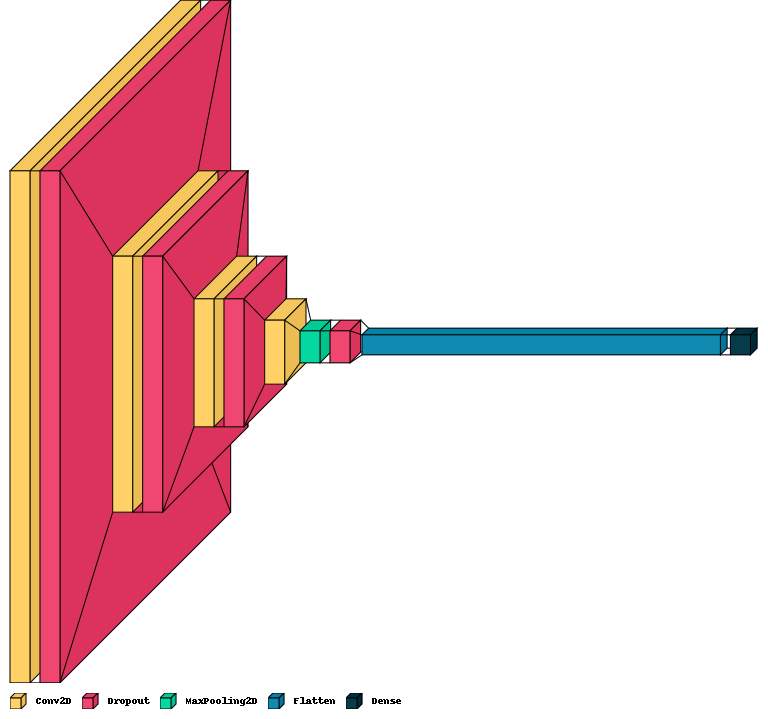

In [207]:
#from tensorflow.keras.utils import plot_model
import visualkeras
from PIL import ImageFont


model.summary()


visualkeras.layered_view(model, legend=True)

In [208]:
def visualizacion_resultados(history):
  
  fig, ax = plt.subplots(1,2)
  acc = history.history['acc']
  loss = history.history['loss']
  val_acc = history.history['val_acc']
  val_loss = history.history['val_loss']
  epochs  = range(len(acc))
  fig.set_size_inches(16,9)

  ax[0].plot(epochs,acc,'go-',label = 'Entrenamiento accuracy')
  ax[0].plot(epochs,val_acc,'ro-',label = 'validacion acurracy')
  ax[0].set_title('Entrenamiento & validacion accuracy')
  ax[0].legend()
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('accuracy')

  ax[1].plot(epochs,loss,'go-',label = 'Entrenamiento Loss')
  ax[1].plot(epochs,val_loss,'ro-',label = 'validacion Loss')
  ax[1].set_title('Entrenamiento & validacion Test')
  ax[1].legend()
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')

  plt.show()

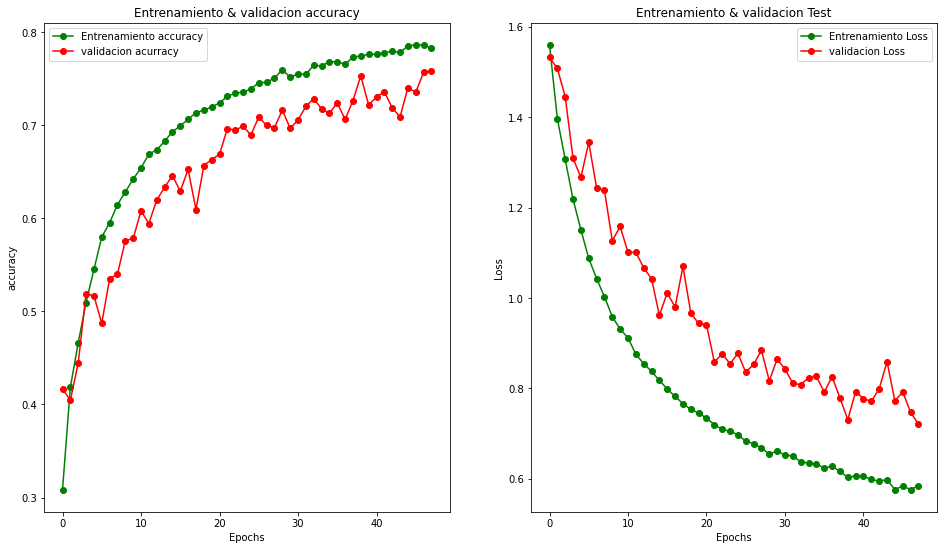

In [209]:
visualizacion_resultados(model_train)

# **Generate predictions**

In [23]:
model.save(r"models/prueba.h5") 

In [211]:
predicted_classes2 = model.predict(test_X)


In [212]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [213]:
predicted_classes.shape, test_Y.shape

((2736,), (2736,))

In [214]:
#rounded_labels = np.argmax(test_Y, axis=1)
rounded_labels = test_Y
rounded_labels[5]

2

In [191]:
model.evaluate(test_X,test_Y)

2736/2736 [==============================] - 1s 394us/sample - loss: 0.6749 - acc: 0.7431


[0.6749312947368065, 0.7430556]

# **MATRIX CONFUSION**

In [165]:
from sklearn.metrics import confusion_matrix
import itertools


#predicted_classes_m = np.argmax(predicted_classes,axis=1)
#test_Y_m = np.argmax(test_Y,axis=1)
#Esto es dificil de leer 

#confusion_matrix(test_Y, predicted_classes_m)

cm = confusion_matrix(rounded_labels,predicted_classes)



In [166]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],'.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.savefig(r'C:\Users\hpalm\Desktop\Programacion\Proyecto_de_grado\Jupyter\Matrices de confusion\all_to_one_32_18_1_2deci.png', transparent = False, bbox_inches = 'tight')

Normalized confusion matrix
[[0.78440367 0.04816514 0.06192661 0.03669725 0.06192661 0.00688073]
 [0.0521327  0.77014218 0.07345972 0.03080569 0.07109005 0.00236967]
 [0.0480167  0.03340292 0.84133612 0.04175365 0.03340292 0.00208768]
 [0.0326087  0.03043478 0.06956522 0.79565217 0.06086957 0.01086957]
 [0.0375     0.04166667 0.05       0.03958333 0.80833333 0.02291667]
 [0.         0.00217865 0.00217865 0.         0.0043573  0.9912854 ]]


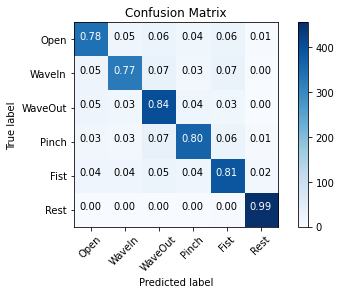

In [167]:
cm_plot_labels = ['Open','WaveIn','WaveOut','Pinch','Fist','Rest']
plot_confusion_matrix(cm,cm_plot_labels, title = 'Confusion Matrix')


# **METRICS OF THE CONFUSION MATRIX**

In [168]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


poly_accuracy = accuracy_score(rounded_labels, predicted_classes)
poly_f1 = f1_score(rounded_labels, predicted_classes, average='weighted')
poly_recall = recall_score(rounded_labels, predicted_classes, average='macro')
poly_precision = precision_score(rounded_labels, predicted_classes, average='macro')

print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))
print('Recall_Score (Polynomial Kernel): ', "%.2f" % (poly_recall*100))
print('Precision (Polynomial Kernel): ', "%.2f" % (poly_precision*100))

Accuracy (Polynomial Kernel):  83.30
F1 (Polynomial Kernel):  83.24
Recall_Score (Polynomial Kernel):  83.19
Precision (Polynomial Kernel):  83.34
